## Amazon chronos-t5-small models for predicting stock's price

https://huggingface.co/amazon/chronos-t5-small

In [1]:
# %pip install git+https://github.com/amazon-science/chronos-forecasting.git
# !pip install transformers

In [4]:
import yfinance as yf
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from chronos import ChronosPipeline

# Dataset 

In [5]:
# 1. fetch data
GetTSLA = yf.Ticker("TSLA")
df_full = GetTSLA.history(start="2023-01-01", end="2025-12-31")
df_full.reset_index(inplace=True)

# 2. split train and test
df_full["Date"] = pd.to_datetime(df_full["Date"])
df_train = df_full[df_full["Date"] < "2025-01-01"]
df_test = df_full[df_full["Date"] >= "2025-01-01"]

# Apply Chronos model 

In [6]:
# 3. load Chronos pipeline
pipeline = ChronosPipeline.from_pretrained(
    "amazon/chronos-t5-small",
    device_map="cuda" if torch.cuda.is_available() else "cpu",
    torch_dtype=torch.bfloat16,
)

# 4. context
context = torch.tensor(df_train["Close"].values, dtype=torch.float32)

# 5. predict
prediction_length = len(df_test)
forecast = pipeline.predict(context, prediction_length=prediction_length)

# 6. confidence interval : 30%, 50%, 80%
low, median, high = np.quantile(forecast[0].numpy(), [0.3, 0.5, 0.8], axis=0)

# 7. index and actual
forecast_index = df_test["Date"].values
actual_2025 = df_test["Close"].values

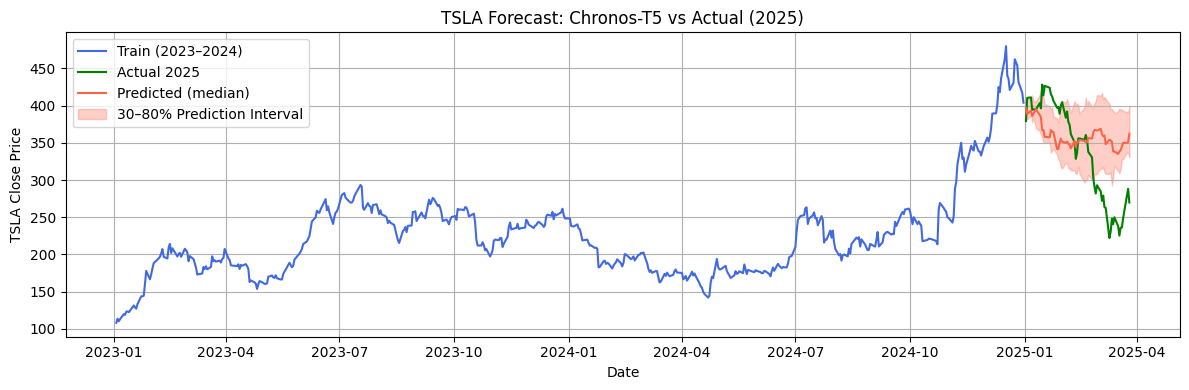

In [12]:
# 8. visualize
plt.figure(figsize=(12, 4))
# plt.plot(df_full["Date"], df_full["Close"], color="lightgray", label="Full Historical Data")
plt.plot(df_train["Date"], df_train["Close"], color="royalblue", label="Train (2023–2024)")
plt.plot(forecast_index, actual_2025, color="green", label="Actual 2025")
plt.plot(forecast_index, median, color="tomato", label="Predicted (median)")
plt.fill_between(forecast_index, low, high, color="tomato", alpha=0.3, label="30–80% Prediction Interval")
plt.title("TSLA Forecast: Chronos-T5 vs Actual (2025)")
plt.xlabel("Date")
plt.ylabel("TSLA Close Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [8]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# actual_2025: 실제 종가 값 (2025년)
# median: 모델이 예측한 중앙값
# 두 배열 길이 동일해야 함

mae = mean_absolute_error(actual_2025, median)
mse = mean_squared_error(actual_2025, median)
rmse = np.sqrt(mse)

print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")


MAE: 52.6674
MSE: 4128.4633
RMSE: 64.2531


In [9]:
 # original code
pipeline = ChronosPipeline.from_pretrained(
  "amazon/chronos-t5-small",
  device_map="cuda",
  torch_dtype=torch.bfloat16,
)


# context must be either a 1D tensor, a list of 1D tensors,
# or a left-padded 2D tensor with batch as the first dimension
context = torch.tensor(df["#Passengers"])
prediction_length = 12
forecast = pipeline.predict(context, prediction_length)  # shape [num_series, num_samples, prediction_length]

# visualize the forecast
forecast_index = range(len(df), len(df) + prediction_length)
low, median, high = np.quantile(forecast[0].numpy(), [0.1, 0.5, 0.9], axis=0)

plt.figure(figsize=(8, 4))
plt.plot(df["#Passengers"], color="royalblue", label="historical data")
plt.plot(forecast_index, median, color="tomato", label="median forecast")
plt.fill_between(forecast_index, low, high, color="tomato", alpha=0.3, label="80% prediction interval")
plt.legend()
plt.grid()
plt.show()



AssertionError: Torch not compiled with CUDA enabled